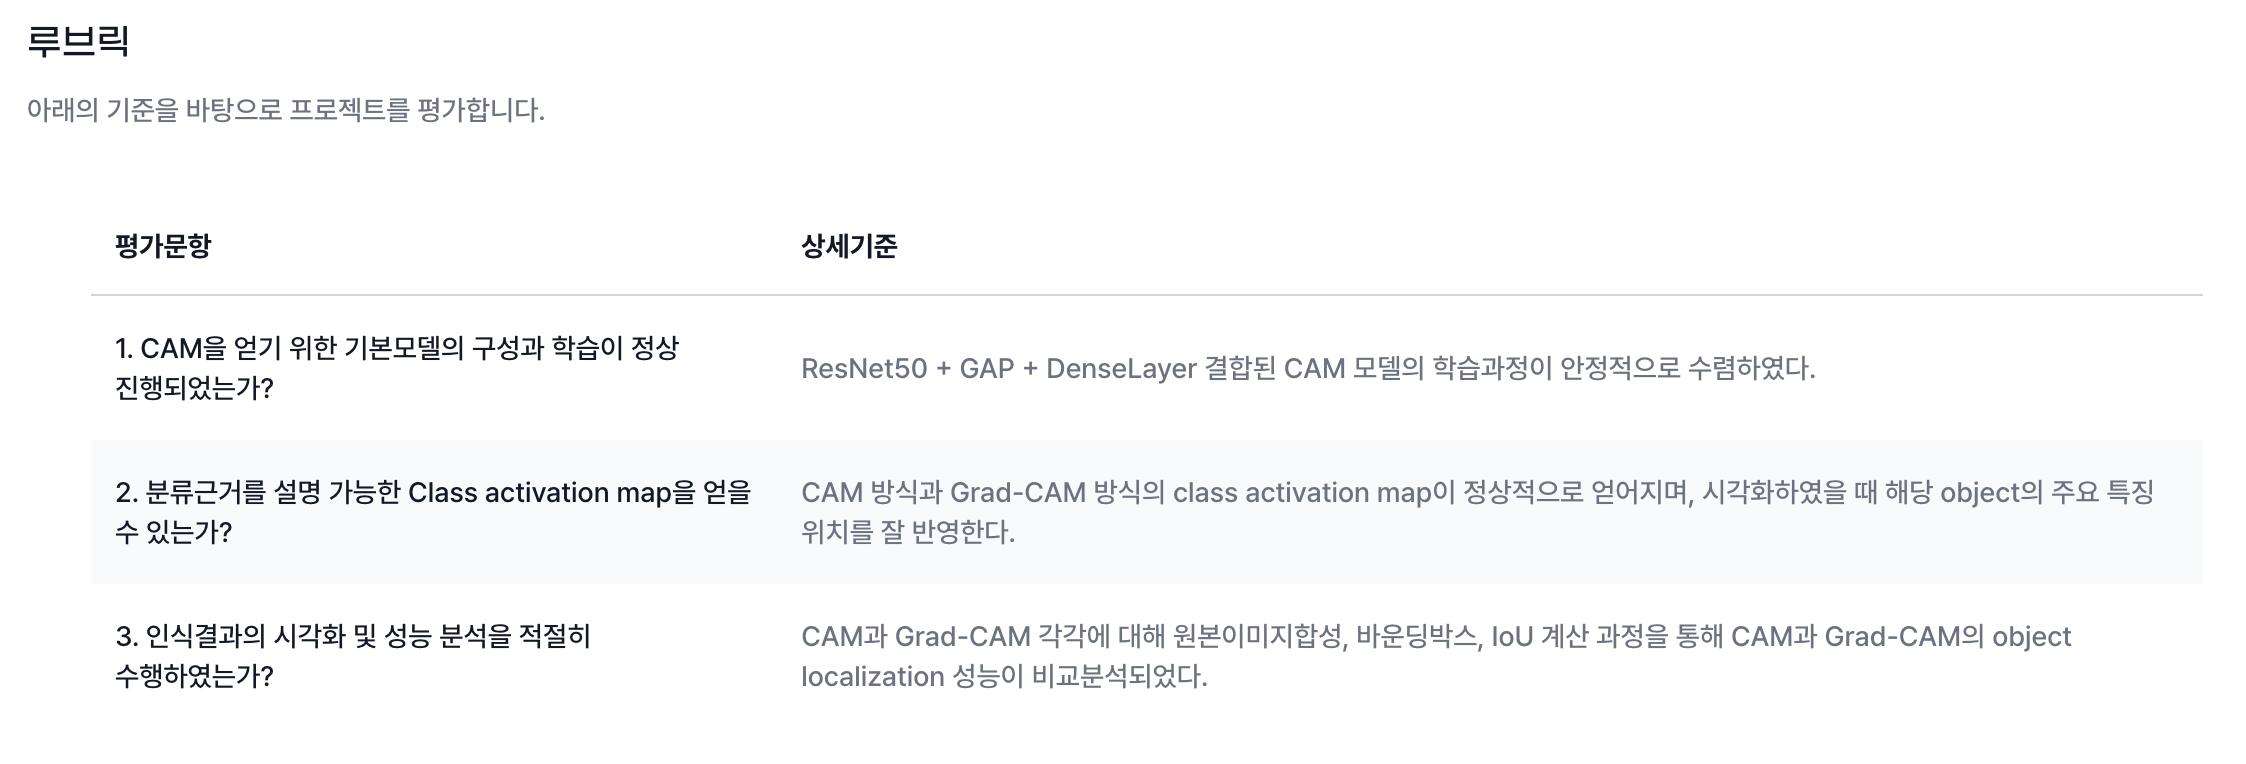

1. 
- 기본모델
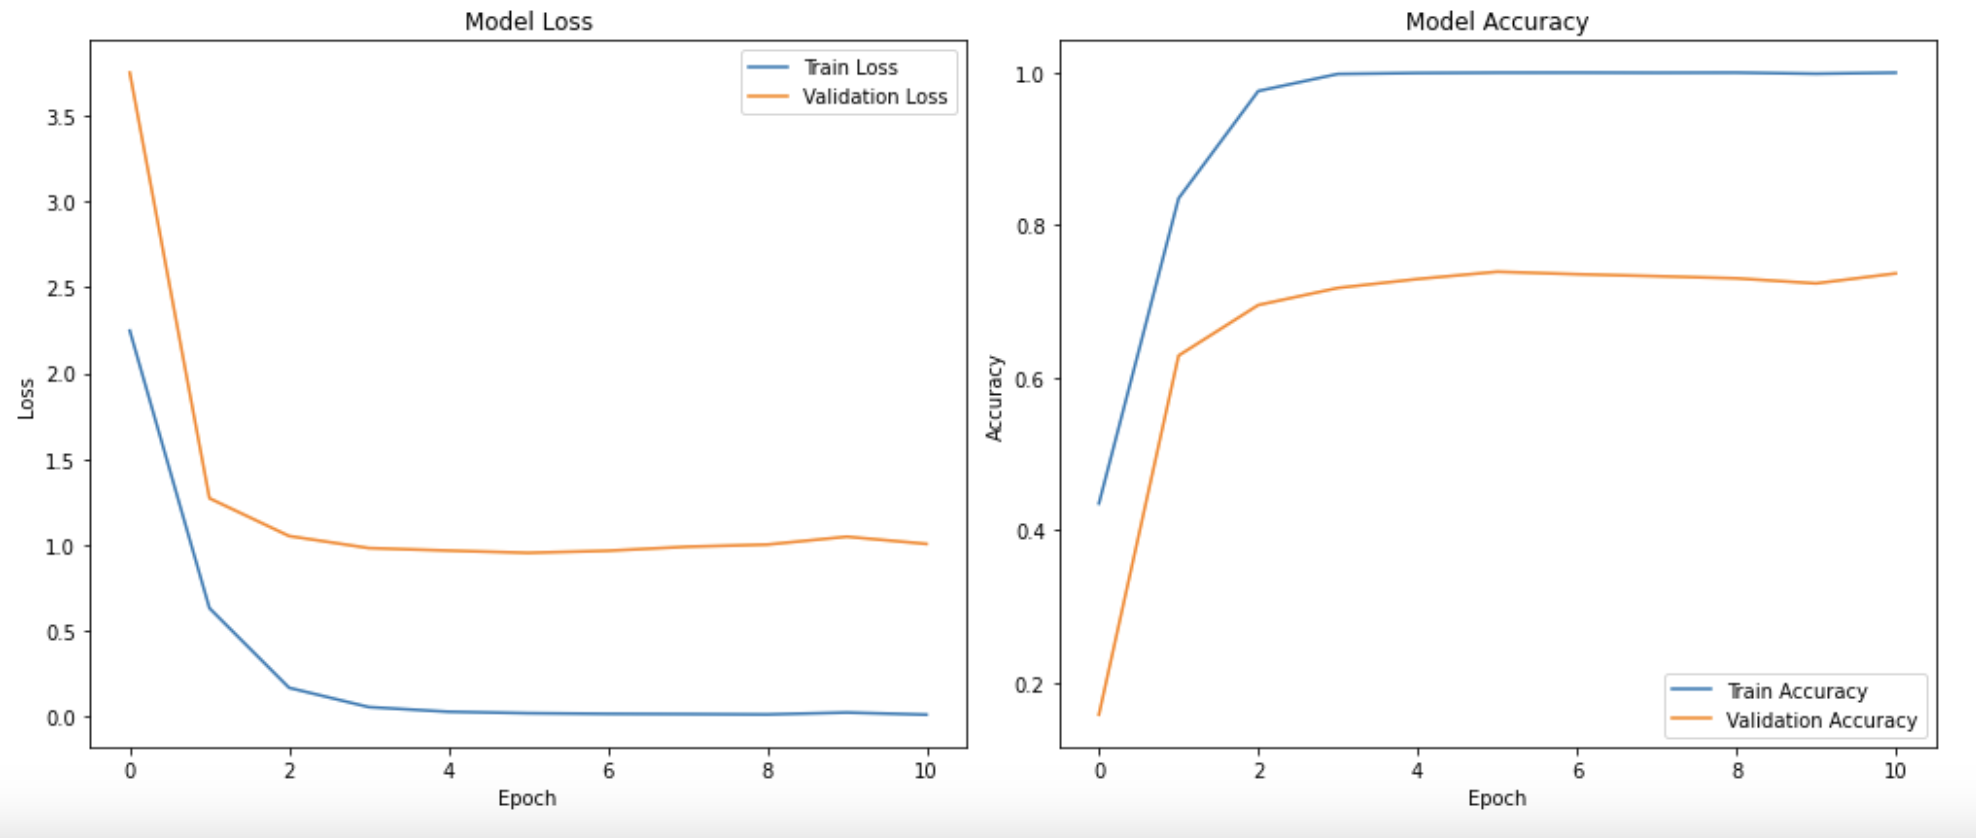

- augment 적용한 모델
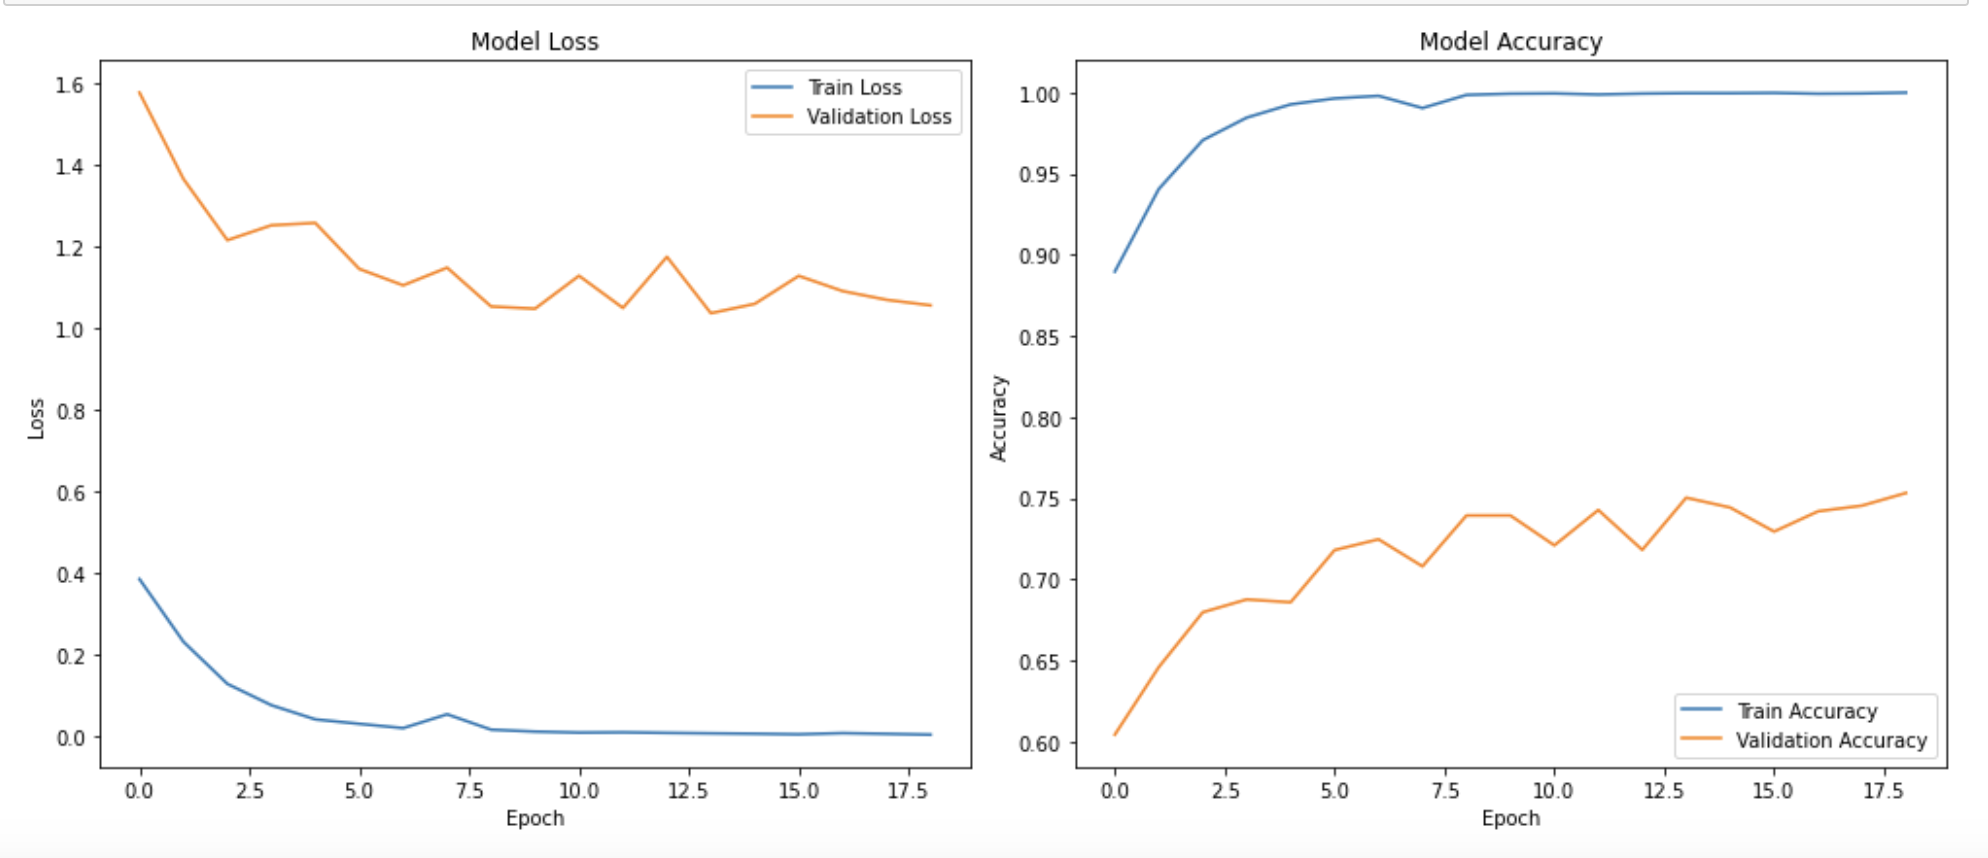

2. 
1) CAM 모델을 통한 class activation map
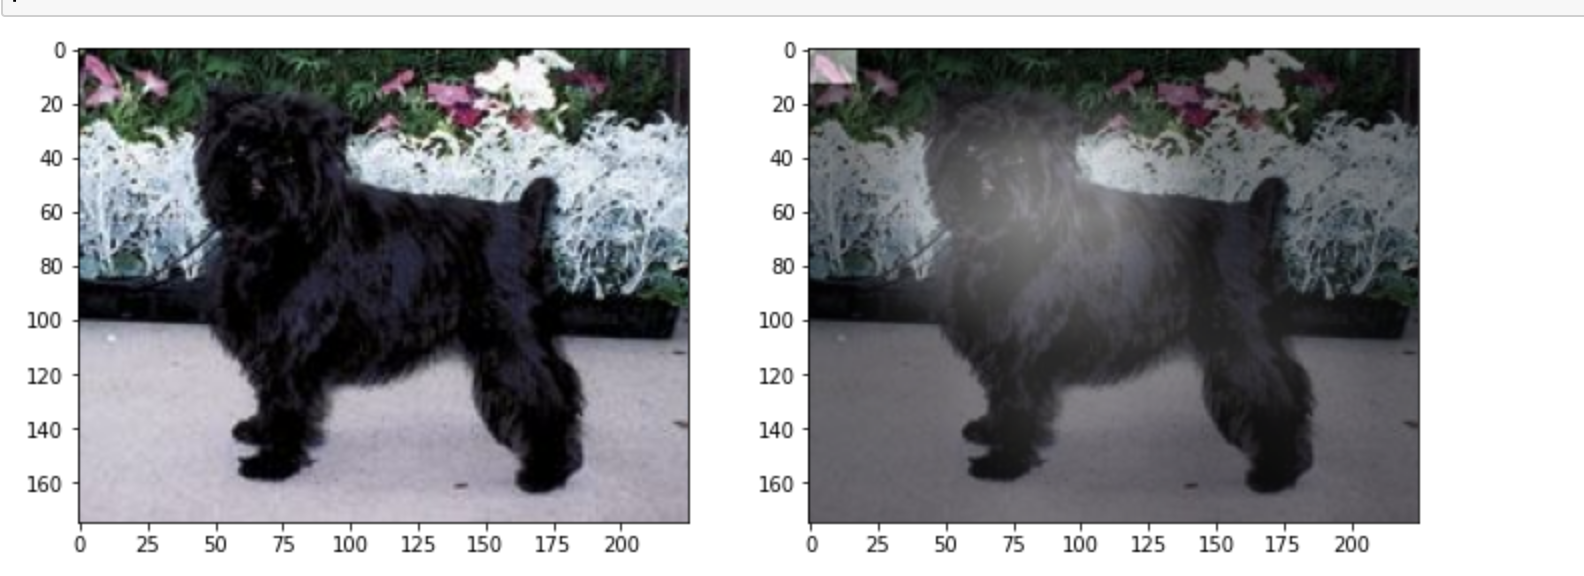

2) grad-CAM (conv5_block3_out 레이어) 시각화
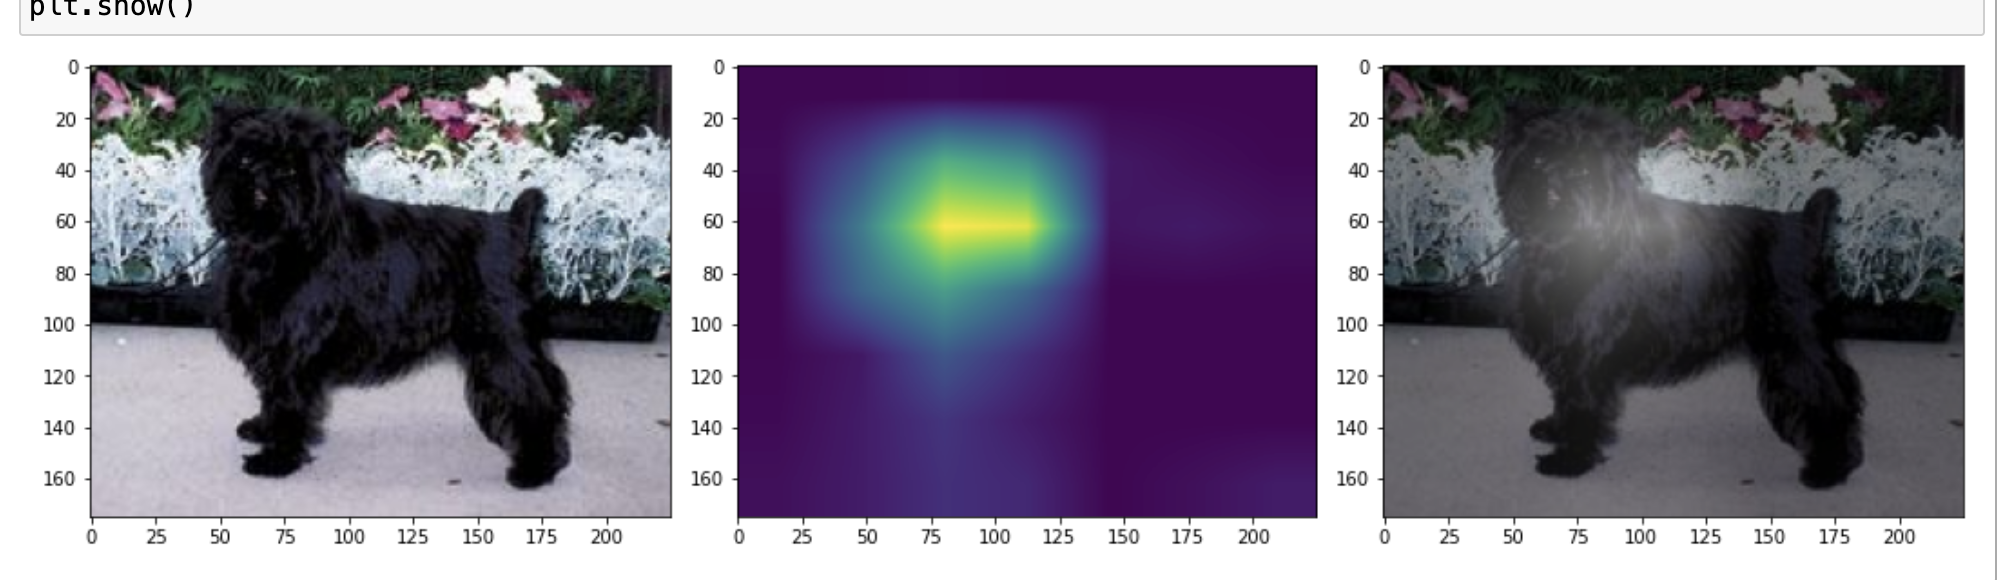


3) grad-CAM (conv4_block3_out 레이어) 시각화
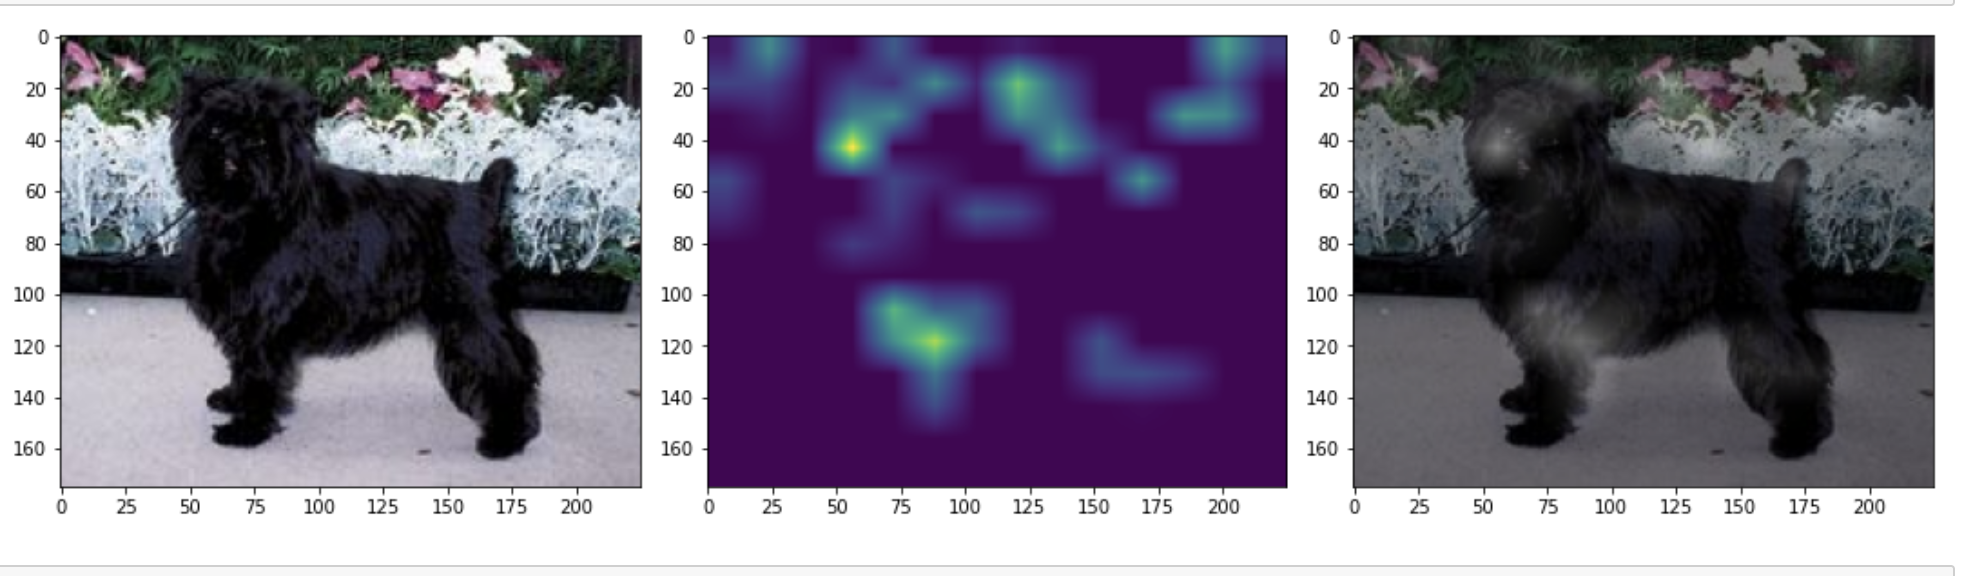

4) grad-CAM (conv4_block3_out 레이어) 시각화
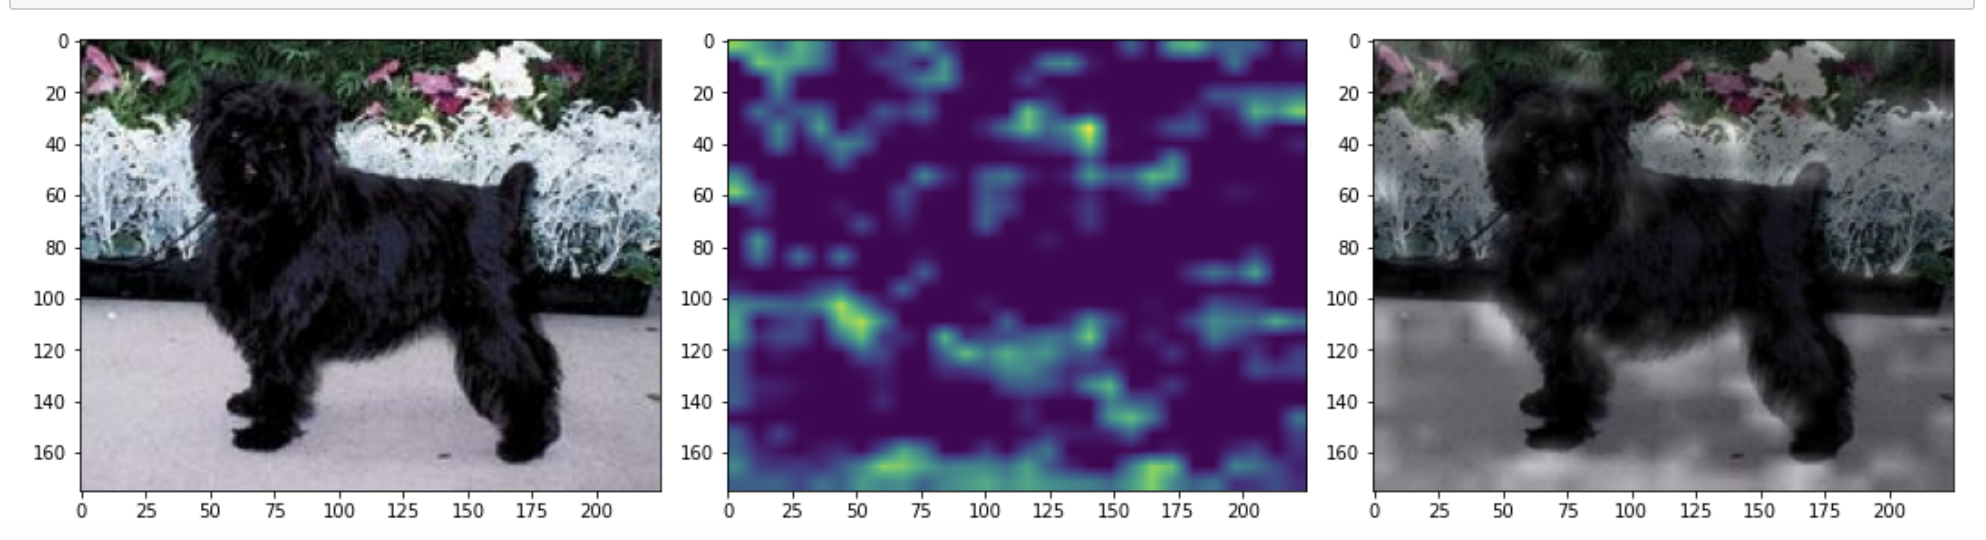

3. 
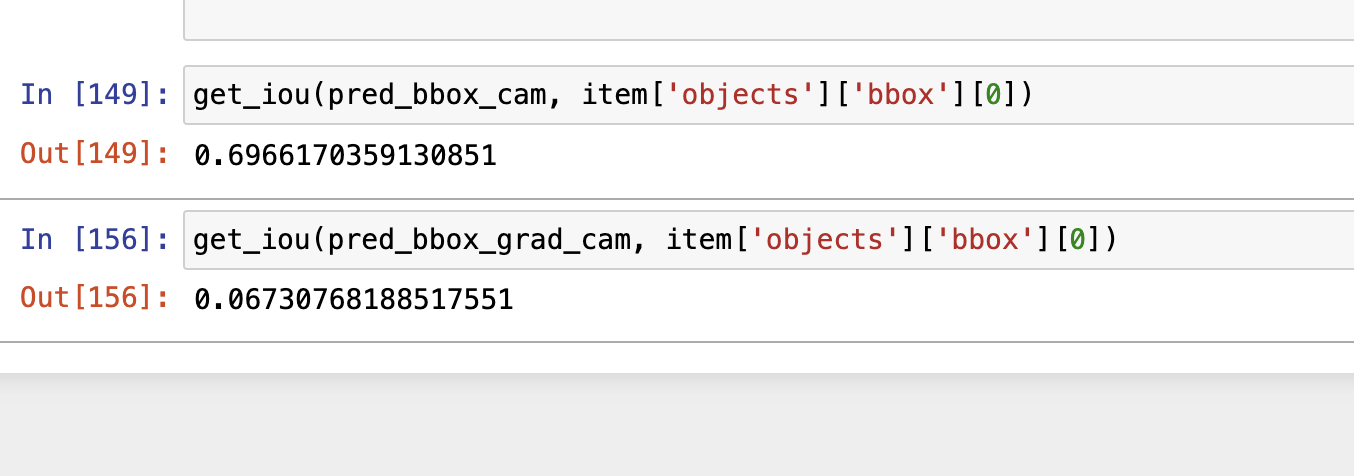

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [2]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


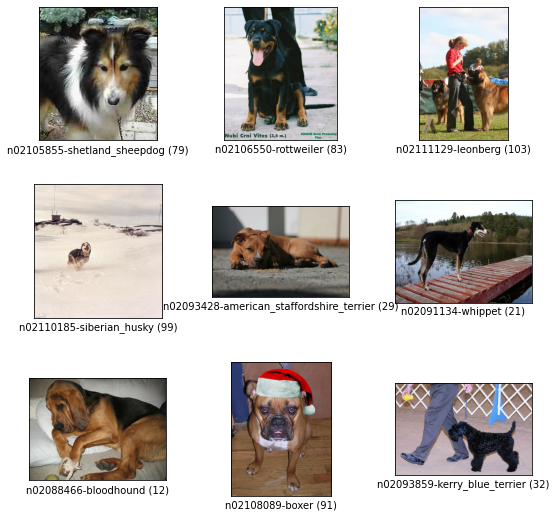

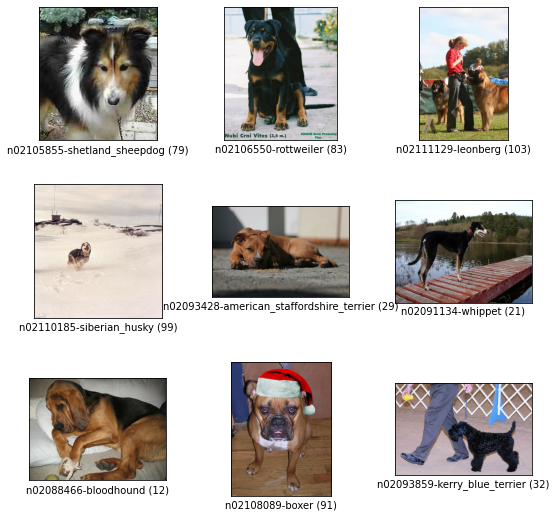

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)

1. 데이터 가져오기 및 전처리

In [89]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, with_aug=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [90]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [38]:
# 배치가 아닌 개별 이미지 단위로 프로세스 하기 위한 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

# item = get_one(ds_test)
# print(item['label'])
# plt.imshow(item['image'])
# plt.show()

In [42]:
# CAM 기본 모델 학습


# ResNet50 기반 모델 (Imagenet 가중치 사용)
num_classes = ds_info.features["label"].num_classes  # 클래스 개수 가져오기
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기 fully connected layer 제거
    weights='imagenet',   # pretrained weights on imagenet
    input_shape=(224, 224, 3),
    pooling='avg',        # Global Average Pooling 적용
)

# 특성 맵을 활용한 Dense Layer 추가
x = base_model.output  # ResNet50에서 추출한 특징 맵
preds = keras.layers.Dense(num_classes, activation='softmax')(x)  # 클래스 예측을 위한 Dense Layer

# CAM 모델 생성
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

# 모델 요약
cam_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [43]:
# 모델학습 및 최적 모델 저장


# 모델 저장 경로 설정
save_dir = 'aiffel/aiffel/class_activation_map'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 저장할 모델 경로
model_path = os.path.join(save_dir, 'cam_model_best.h5')


# 모델 컴파일
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

# EarlyStopping 및 ModelCheckpoint 콜백 정의
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 검증 손실이 줄지 않으면 학습을 중단
    patience=5,          # 성능 개선이 없으면 5번의 epoch 후 학습 중단
    restore_best_weights=True  # 가장 성능이 좋은 모델을 복원
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_path,  # 모델을 저장할 경로
    monitor='val_loss',   # 검증 손실이 가장 낮은 모델을 저장
    save_best_only=True   # 가장 좋은 모델만 저장
)

# 모델 학습
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,  # 최대 에포크 수
    callbacks=[early_stopping, model_checkpoint],  # EarlyStopping과 ModelCheckpoint 콜백 사용
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

# 모델 저장 (EarlyStopping이 적용된 최적의 모델이 저장됨)
print(f"Model saved to: {model_path}")

Epoch 1/20
750/750 [==============================] - 153s 198ms/step - loss: 2.2482 - accuracy: 0.4353 - val_loss: 3.7517 - val_accuracy: 0.1587


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 148s 198ms/step - loss: 0.6303 - accuracy: 0.8349 - val_loss: 1.2708 - val_accuracy: 0.6290
Epoch 3/20
750/750 [==============================] - 148s 197ms/step - loss: 0.1660 - accuracy: 0.9755 - val_loss: 1.0507 - val_accuracy: 0.6952
Epoch 4/20
750/750 [==============================] - 148s 197ms/step - loss: 0.0537 - accuracy: 0.9978 - val_loss: 0.9804 - val_accuracy: 0.7176
Epoch 5/20
750/750 [==============================] - 148s 197ms/step - loss: 0.0265 - accuracy: 0.9991 - val_loss: 0.9657 - val_accuracy: 0.7292
Epoch 6/20
750/750 [==============================] - 148s 197ms/step - loss: 0.0181 - accuracy: 0.9995 - val_loss: 0.9526 - val_accuracy: 0.7388
Epoch 7/20
750/750 [==============================] - 148s 198ms/step - loss: 0.0143 - accuracy: 0.9996 - val_loss: 0.9648 - val_accuracy: 0.7355
Epoch 8/20
750/750 [==============================] - 148s 197ms/step - loss: 0.0129 - accuracy: 0.9994 - val_loss: 0.9884 -

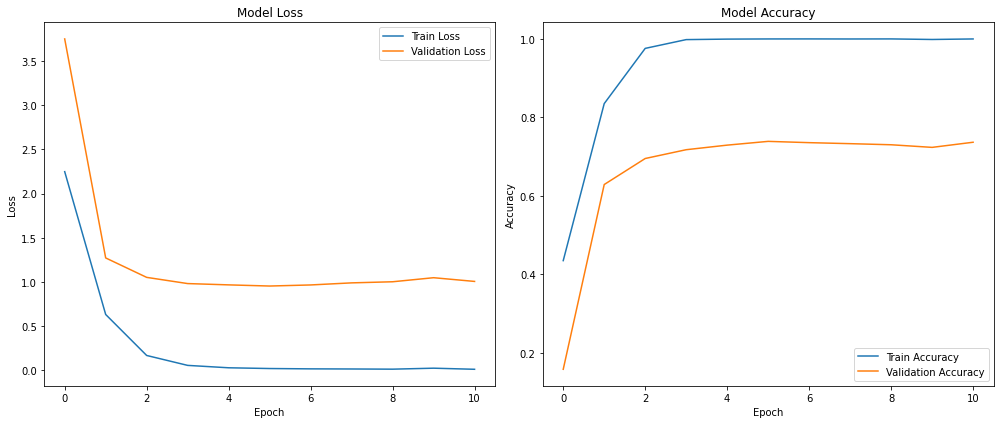

In [45]:
# 학습 과정에서 기록된 손실과 정확도 데이터
history = history_cam_model  # model.fit() 호출 결과

# 첫 번째 그래프: 손실 (Loss) 그래프
plt.figure(figsize=(14, 6))  # 전체 그래프 크기 설정


# 첫 번째 그래프 (손실 그래프): 1행 2열 중 첫 번째 위치
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


# 두 번째 그래프 (정확도 그래프): 1행 2열 중 두 번째 위치
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')


# 그래프를 그리기
plt.tight_layout()  # 레이아웃 자동 조정
plt.show()

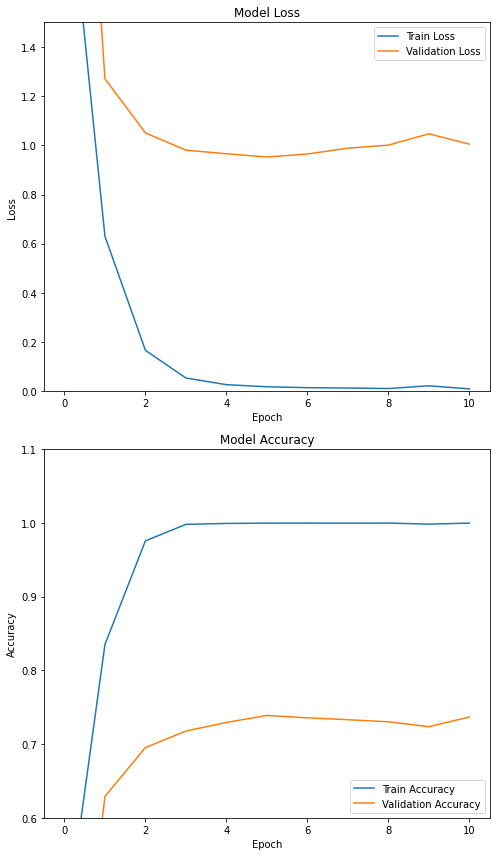

In [86]:
# 학습 과정에서 기록된 손실과 정확도 데이터
history = history_cam_model  # model.fit() 호출 결과

# 첫 번째 그래프: 손실 (Loss) 그래프
plt.figure(figsize=(7, 12))  # 전체 그래프 크기 설정


# 첫 번째 그래프 (손실 그래프): 1행 2열 중 첫 번째 위치
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylim(0.0, 1.5)  # x축을 20에서 80까지로 설정
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


# 두 번째 그래프 (정확도 그래프): 1행 2열 중 두 번째 위치
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylim(0.6, 1.1)  # x축을 20에서 80까지로 설정
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')


# 그래프를 그리기
plt.tight_layout()  # 레이아웃 자동 조정
plt.show()

In [91]:
# 모델학습 및 최적 모델 저장


# 모델 저장 경로 설정
save_dir = 'aiffel/aiffel/class_activation_map'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 저장할 모델 경로
model_path = os.path.join(save_dir, 'cam_model_aug_best.h5')


# 모델 컴파일
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

# EarlyStopping 및 ModelCheckpoint 콜백 정의
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 검증 손실이 줄지 않으면 학습을 중단
    patience=2,          # 성능 개선이 없으면 5번의 epoch 후 학습 중단
    restore_best_weights=True  # 가장 성능이 좋은 모델을 복원
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_path,  # 모델을 저장할 경로
    monitor='val_loss',   # 검증 손실이 가장 낮은 모델을 저장
    save_best_only=True   # 가장 좋은 모델만 저장
)

# 모델 학습
history_cam_model = cam_model.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,  # 최대 에포크 수
    callbacks=[early_stopping, model_checkpoint],  # EarlyStopping과 ModelCheckpoint 콜백 사용
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

# 모델 저장 (EarlyStopping이 적용된 최적의 모델이 저장됨)
print(f"Model saved to: {model_path}")

Epoch 1/20
750/750 [==============================] - 152s 198ms/step - loss: 0.3837 - accuracy: 0.8897 - val_loss: 1.5759 - val_accuracy: 0.6041
Epoch 2/20
750/750 [==============================] - 148s 197ms/step - loss: 0.2303 - accuracy: 0.9406 - val_loss: 1.3644 - val_accuracy: 0.6458
Epoch 3/20
750/750 [==============================] - 148s 197ms/step - loss: 0.1269 - accuracy: 0.9707 - val_loss: 1.2143 - val_accuracy: 0.6796
Epoch 4/20
750/750 [==============================] - 148s 198ms/step - loss: 0.0747 - accuracy: 0.9846 - val_loss: 1.2507 - val_accuracy: 0.6875
Epoch 5/20
750/750 [==============================] - 148s 197ms/step - loss: 0.0399 - accuracy: 0.9927 - val_loss: 1.2566 - val_accuracy: 0.6858
Epoch 6/20
750/750 [==============================] - 148s 198ms/step - loss: 0.0290 - accuracy: 0.9964 - val_loss: 1.1439 - val_accuracy: 0.7179
Epoch 7/20
750/750 [==============================] - 148s 198ms/step - loss: 0.0185 - accuracy: 0.9980 - val_loss: 1.1037 -

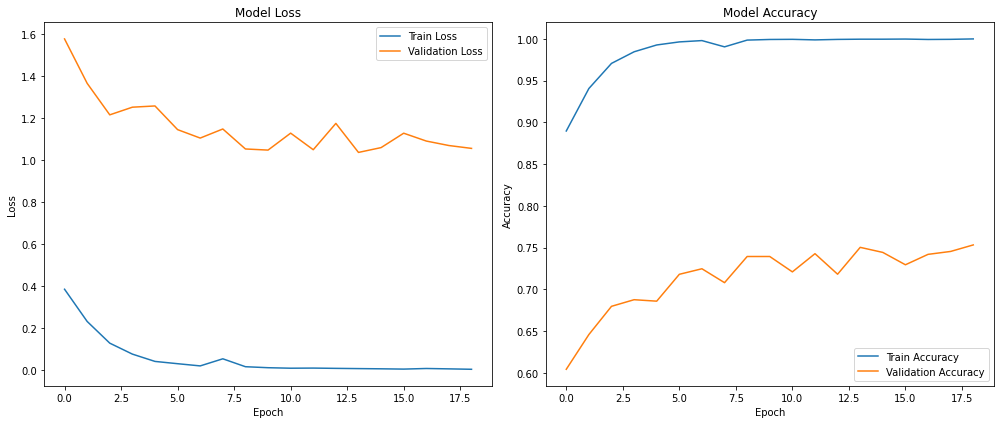

In [143]:
# 학습 과정에서 기록된 손실과 정확도 데이터
history = history_cam_model  # model.fit() 호출 결과

# 첫 번째 그래프: 손실 (Loss) 그래프
plt.figure(figsize=(14, 6))  # 전체 그래프 크기 설정


# 첫 번째 그래프 (손실 그래프): 1행 2열 중 첫 번째 위치
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


# 두 번째 그래프 (정확도 그래프): 1행 2열 중 두 번째 위치
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')


# 그래프를 그리기
plt.tight_layout()  # 레이아웃 자동 조정
plt.show()

In [ ]:
# 하이퍼파라미터 최적화 - 실행 못함
#!pip install keras_tuner
import keras_tuner as kt


# 최적화할 모델 정의 함수
def build_model(hp):
    num_classes = ds_info.features["label"].num_classes  # 클래스 개수 가져오기

    # ResNet50 기반 모델 (Imagenet 가중치 사용)
    base_model = keras.applications.resnet50.ResNet50(
        include_top=False,    # Imagenet 분류기 fully connected layer 제거
        weights='imagenet',   # pretrained weights on imagenet
        input_shape=(224, 224, 3),
        pooling='avg',        # Global Average Pooling 적용
    )
    
    # 특성 맵을 활용한 Dense Layer 추가
    x = base_model.output  # ResNet50에서 추출한 특징 맵
    
    # 하이퍼파라미터 최적화: Dense Layer의 유닛 수
    units = hp.Int('units', min_value=32, max_value=512, step=32)
    x = keras.layers.Dense(units, activation='relu')(x)
    
    # 클래스 예측을 위한 Dense Layer (고정)
    preds = keras.layers.Dense(num_classes, activation='softmax')(x)

    # CAM 모델 생성
    cam_model = keras.Model(inputs=base_model.input, outputs=preds)
    
    # 하이퍼파라미터 최적화: 학습률 (learning rate)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    
    # 모델 컴파일
    cam_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy'],
    )

    return cam_model

# Keras Tuner 설정
tuner = kt.RandomSearch(
    build_model,  # 모델 정의 함수
    objective='val_loss',  # 최적화할 목표 (validation loss)
    max_trials=10,  # 시도할 하이퍼파라미터 조합 수
    executions_per_trial=2,  # 각 하이퍼파라미터 조합당 2번 실행하여 평균
    directory='tuner_results',  # 결과 저장 디렉토리
    project_name='cam_model_hyperparameter_tuning'  # 프로젝트 이름
)

# 데이터셋 준비 (ds_train_norm과 ds_val_norm는 미리 준비된 데이터셋입니다)
# 하이퍼파라미터 검색 실행
tuner.search(ds_train_norm, validation_data=ds_val_norm, epochs=10)

# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Dense units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# 최적의 하이퍼파라미터로 모델 재학습
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    ds_train_norm,
    validation_data=ds_val_norm,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],  # EarlyStopping과 ModelCheckpoint 콜백 사용
    verbose=1
)

# 모델 저장
# model.save('/aiffel/class_activation_map/cam_model_best_tuned.h5')

2. CAM 모델 학습 (이전에 학습한 모델 불러와서 사용하기)

In [131]:
# 학습된 모델 불러오기
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_aug_best.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

100


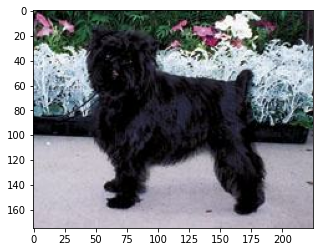

In [132]:
# 새로운 이미지

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [133]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 이미지 전처리
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


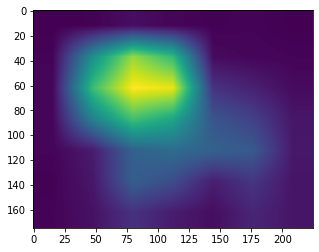

In [134]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [95]:
# 원본 이미지와 합쳐보기 
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

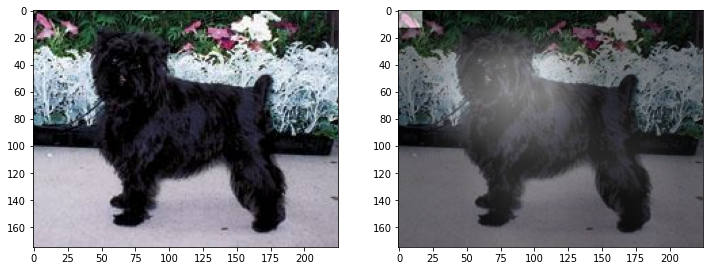

In [135]:
plt.figure(figsize=(12, 6))  # 전체 그래프 크기 설정

# 원본 이미지
plt.subplot(1, 2, 1)
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
plt.imshow(origin_image)

# 원본과 합쳐진 이미지
plt.subplot(1, 2, 2)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

3. grad-CAM 구현하기

In [103]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

여러 레이어의 gradCAM 이미지를 뽑아서 직접 확인

In [151]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

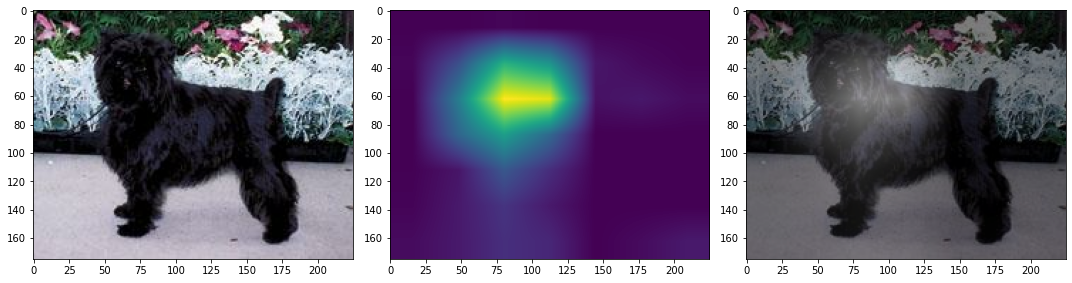

In [136]:
# conv5_block3_out layer의 output 

LAYER_NAME='conv5_block3_out'
plt.figure(figsize=(15, 8))  # 전체 그래프 크기 설정

grad_cam_image = generate_grad_cam(cam_model, LAYER_NAME, item)


# 원본 이미지
plt.subplot(1, 3, 1)
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
plt.imshow(origin_image)

# CAM 영역
plt.subplot(1, 3, 2)
plt.imshow(grad_cam_image)

# 원본과 합쳐진 이미지
plt.subplot(1, 3, 3)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)


plt.tight_layout()
plt.show()

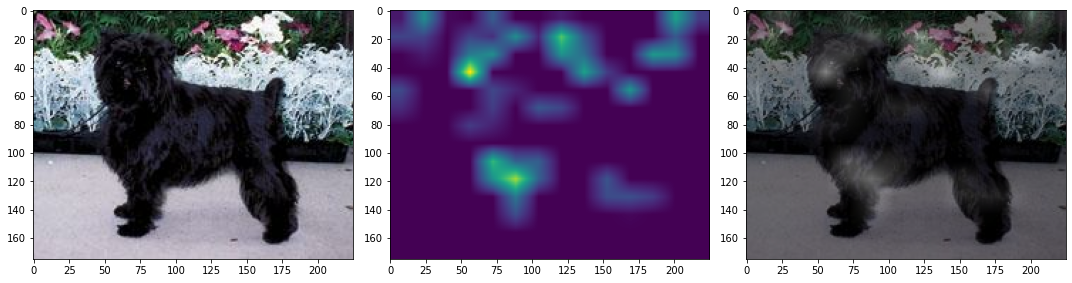

In [152]:
# conv4_block3_out layer의 output 

LAYER_NAME='conv4_block3_out'
plt.figure(figsize=(15, 8))  # 전체 그래프 크기 설정

grad_cam_image = generate_grad_cam(cam_model, LAYER_NAME, item)


# 원본 이미지
plt.subplot(1, 3, 1)
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
plt.imshow(origin_image)

# CAM 영역
plt.subplot(1, 3, 2)
plt.imshow(grad_cam_image)

# 원본과 합쳐진 이미지
plt.subplot(1, 3, 3)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)


plt.tight_layout()
plt.show()

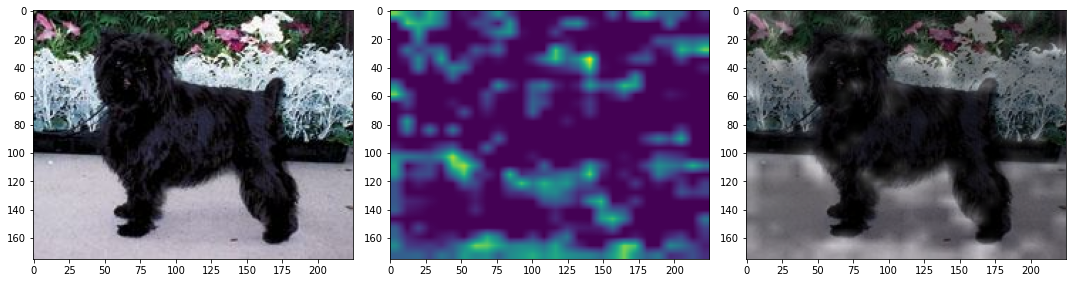

In [145]:
# conv3_block3_out layer의 output 

LAYER_NAME='conv3_block3_out'
plt.figure(figsize=(15, 8))  # 전체 그래프 크기 설정

grad_cam_image = generate_grad_cam(cam_model, LAYER_NAME, item)


# 원본 이미지
plt.subplot(1, 3, 1)
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
plt.imshow(origin_image)

# CAM 영역
plt.subplot(1, 3, 2)
plt.imshow(grad_cam_image)

# 원본과 합쳐진 이미지
plt.subplot(1, 3, 3)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)


plt.tight_layout()
plt.show()

4. 바운딩 박스 구하기

In [57]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


In [137]:
rect_cam = get_bbox(cam_image)
rect_cam

array([[ 18,  13],
       [224,  13],
       [224, 174],
       [ 18, 174]])

In [153]:
rect_grad_cam = get_bbox(grad_cam_image)
rect_grad_cam

array([[140, 109],
       [195, 109],
       [195, 141],
       [140, 141]])

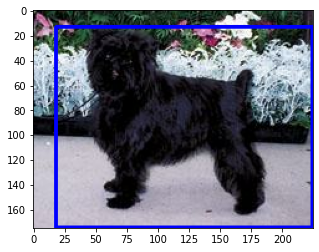

In [139]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

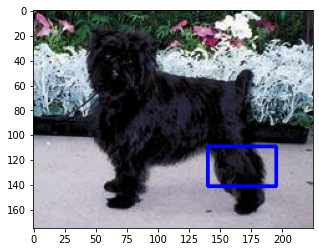

In [154]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

IoU

In [66]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [146]:
# rect의 bbox
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_cam

[0.07428571428571429, 0.08, 0.9942857142857143, 0.9955555555555555]

In [155]:
# rect의 bbox
pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])
pred_bbox_grad_cam

[0.6228571428571429,
 0.6222222222222222,
 0.8057142857142857,
 0.8666666666666667]

In [148]:
# ground truth 
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [76]:
def get_iou(boxA, boxB):
    # get iou between two bbox
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


In [149]:
get_iou(pred_bbox_cam, item['objects']['bbox'][0])

0.6966170359130851

In [156]:
get_iou(pred_bbox_grad_cam, item['objects']['bbox'][0])

0.06730768188517551